#### Objective
$$\max_\theta E[R \, | \, \pi(\cdot, \theta)]$$

where $R$ is the reward and $\theta$ is a parameter to the policy $\pi$ which we aim to maximise.

Cross-entropy is a derivative free approach, where we view the world as a black box (i.e. we only observe the reward).

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from gym.spaces import Discrete, Box

# Some set up here for using the OpenAI gym environments

class DeterministicDiscreteActionLinearPolicy(object):
    def __init__(self, theta, ob_space, ac_space):
        dim_ob = ob_space.shape[0]
        n_actions = ac_space.n
        assert len(theta) == (dim_ob + 1) * n_actions
        self.W = theta[0 : dim_ob * n_actions].reshape(dim_ob, n_actions)
        self.b = theta[dim_ob * n_actions : None].reshape(1, n_actions)

    def act(self, ob):
        y = ob.dot(self.W) + self.b
        a = y.argmax()
        return a

class DeterministicContinuousActionLinearPolicy(object):
    def __init__(self, theta, ob_space, ac_space):
        self.ac_space = ac_space
        dim_ob = ob_space.shape[0]
        dim_ac = ac_space.shape[0]
        assert len(theta) == (dim_ob + 1) * dim_ac
        self.W = theta[0 : dim_ob * dim_ac].reshape(dim_ob, dim_ac)
        self.b = theta[dim_ob * dim_ac : None]

    def act(self, ob):
        a = np.clip(ob.dot(self.W) + self.b, self.ac_space.low, self.ac_space.high)
        return a

def do_episode(policy, env, num_steps, render=False):
    episode_reward = 0
    state, _ = env.reset()
    for t in range(num_steps):
        action = policy.act(state)
        (state, reward, exit, _, _) = env.step(action)
        episode_reward += reward
        if render and t % 3 == 0: 
            env.render()
        if exit: 
            break
            
    return episode_reward

env = None
def noisy_evaluation(theta):
    policy = make_policy(theta)
    reward = do_episode(policy, env, num_steps)
    return reward

def make_policy(theta):
    if isinstance(env.action_space, Discrete):
        return DeterministicDiscreteActionLinearPolicy(theta,
            env.observation_space, env.action_space)
    elif isinstance(env.action_space, Box):
        return DeterministicContinuousActionLinearPolicy(theta,
            env.observation_space, env.action_space)
    else:
        raise NotImplementedError

env = gym.make('CartPole-v1') #, render_mode="human")
# env = gym.make('Pendulum-v1', render_mode="human")
# env = gym.make('Acrobot-v1'), render_mode="human")
# env = gym.make('MountainCar-v0', render_mode="human")

if isinstance(env.action_space, Discrete):
    dim_theta = (env.observation_space.shape[0]+1) * env.action_space.n
elif isinstance(env.action_space, Box):
    dim_theta = (env.observation_space.shape[0]+1) * env.action_space.shape[0]
else:
    raise NotImplementedError

#### Cross-entropy method
Initialise $\mu \in \mathbb{R}^d$, $\sigma \in \mathbb{R}^d$

for iteration = $1, 2, \ldots$ do

{

Collect $n$ samples of $\theta_i \sim N(\theta, \mathrm{diag}(\sigma))$

Perform noisy evaluation $R_i \sim \theta_i$

Select the top $p\%$ of samples (the "elite set")

Fit a normal distribution to the elite set and update $\mu, \sigma$

}

Return $\mu$

In [2]:
# Run cross-entropy

num_steps = 500 # maximum length of episode
n_iter = 100 # number of iterations of CEM
batch_size = 25 # number of samples per batch
elite_frac = 0.2 # fraction of samples used as elite set

mean_rewards = []

theta_mean = np.zeros(dim_theta)
theta_std = np.ones(dim_theta)
for iteration in range(n_iter):
    thetas = [np.random.normal(theta_mean, theta_std, dim_theta) for i in range(batch_size)]
    rewards = [noisy_evaluation(theta) for theta in thetas]
    n_elite = int(batch_size * elite_frac)
    elite_inds = np.argsort(rewards)[batch_size - n_elite:batch_size]
    elite_thetas = [thetas[i] for i in elite_inds]
    theta_mean = np.mean(elite_thetas, axis=0)
    theta_std = np.std(elite_thetas, axis=0)
    print(f"iteration {iteration}. mean f: {np.mean(rewards):.2f}. max f: {np.max(rewards):.2f}")
    mean_rewards.append(np.mean(rewards))
    do_episode(make_policy(theta_mean), env, num_steps, render=True)

iteration 0. mean f: 14.56. max f: 99.00
iteration 1. mean f: 29.12. max f: 208.00
iteration 2. mean f: 46.64. max f: 100.00
iteration 3. mean f: 72.84. max f: 227.00
iteration 4. mean f: 115.16. max f: 241.00


c:\users\joshua\gym\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


iteration 5. mean f: 194.84. max f: 283.00
iteration 6. mean f: 195.96. max f: 298.00
iteration 7. mean f: 226.88. max f: 341.00
iteration 8. mean f: 245.16. max f: 374.00
iteration 9. mean f: 257.44. max f: 382.00
iteration 10. mean f: 260.44. max f: 366.00
iteration 11. mean f: 287.60. max f: 366.00
iteration 12. mean f: 323.56. max f: 419.00
iteration 13. mean f: 291.76. max f: 362.00
iteration 14. mean f: 291.48. max f: 416.00
iteration 15. mean f: 307.40. max f: 394.00
iteration 16. mean f: 281.56. max f: 431.00
iteration 17. mean f: 296.24. max f: 393.00
iteration 18. mean f: 282.00. max f: 392.00
iteration 19. mean f: 313.40. max f: 444.00
iteration 20. mean f: 305.36. max f: 398.00
iteration 21. mean f: 310.36. max f: 424.00
iteration 22. mean f: 317.00. max f: 389.00
iteration 23. mean f: 306.32. max f: 427.00
iteration 24. mean f: 291.32. max f: 392.00
iteration 25. mean f: 292.12. max f: 409.00
iteration 26. mean f: 293.04. max f: 451.00
iteration 27. mean f: 317.84. max f: 

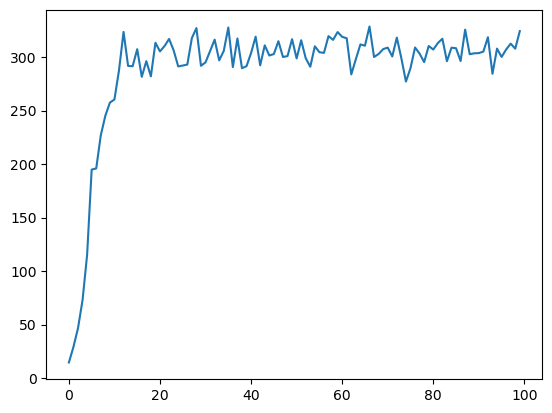

In [3]:
plt.plot(mean_rewards)